In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from hydracv.midline import find_midline_midpoints, find_midline_midpoints_corrected
from hydracv.fluorescence import trace_fluo
from hydracv.utils import utils

In [2]:
BISECTION_DATA_HOME = "/Users/katyabrooun/Google Drive/Shared drives/hydra/data-analysis/Bisection_Full/"
VIDEO_NAME = "71420_ngcamp_hy6_prebisect" # TO MODIFY
BODY_PART = '' # TO MODIFY
EXP_NAME = 'GCaMP6_Bisection_Exp6'# TO MODIFY
SAVE_DIR = '/Users/katyabrooun/Fairhall_Lab/hydra/bisection-data-analysis/exp6/' + BODY_PART + "/" # TO MODIFY

## Midline and length

Requirements: 
- per-frame contours
- tracked data (results from DeepLabCut)

In [3]:
FILE_CONTOUR = BISECTION_DATA_HOME + 'Icy_Contours/' + EXP_NAME + '/' + VIDEO_NAME +  "_ROIs.xml"
FILE_MARKER = BISECTION_DATA_HOME + 'DLC_Data/' + EXP_NAME + "/" \
"71420_ngcamp_hy6_prebisectDLC_resnet50_EXP6-PrebisectDec2shuffle1_35000.csv" # TO MODIFY

In [18]:
# Original find midline code
midpoints_orig = find_midline_midpoints.find_midline(file_contour=FILE_CONTOUR,
                                                     file_marker=FILE_MARKER,
                                                     nseg=40,
                                                     play=False)

Contour loaded, the size is: 7246
Markers loaded, the size is: 7246
Number of missed contours is: 0


100%|██████████| 7246/7246 [00:12<00:00, 579.55it/s]


In [19]:
# Save the original midpoints
FILE_MIDPOINTS = SAVE_DIR + "midpoints_"+VIDEO_NAME+".csv"
df = pd.DataFrame(midpoints_orig)
df.to_csv(FILE_MIDPOINTS, index=False)

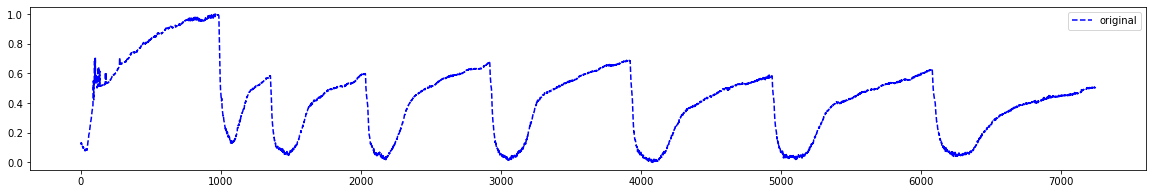

In [20]:
# Plot the length

midpoints_orig_data = find_midline_midpoints_corrected.load_midpoints(FILE_MIDPOINTS)
# midpoints_corr_data = find_midline_midpoints_corrected.load_midpoints(FILE_MIDPOINTS_CORR)

midlens_orig = find_midline_midpoints_corrected.extract_lengths(midpoints_orig_data, normalize=False)
# midlens_corr = find_midline_midpoints_corrected.extract_lengths(midpoints_corr_data)

plt.figure(figsize=(20,3))
# plt.plot(midlens_corr, 'r', label='corrected')
plt.plot(utils.normalize(midlens_orig), 'b--', label='original')
plt.legend()
plt.show()

In [21]:
# Save the lengths
FILE_LENGTH = SAVE_DIR + "lengths_" + VIDEO_NAME + ".csv"
df = pd.DataFrame(midlens_orig)
df.to_csv(FILE_LENGTH, index=False)

## Fluorescence

Requirements: 
- video

Optional:
- single ROI specifying which portion of video frames to compute fluorescence over (useful if there are external objects in video)

In [30]:
FILE_VIDEO = BISECTION_DATA_HOME + "Original_Videos/" + EXP_NAME + "/" + BODY_PART +"/" + VIDEO_NAME + ".avi"
FILE_FLUO_ROI = BISECTION_DATA_HOME + 'Icy_Contours/' + EXP_NAME + '/' + VIDEO_NAME +  "_max_intensity_ROI.xml"

In [36]:
# Calculate fluorescence intensity for each video frame
ROI_list = find_midline_midpoints.load_contour(FILE_FLUO_ROI)
ROI = ROI_list[0]
fluo = trace_fluo.trace(FILE_VIDEO, ROI, display=False)

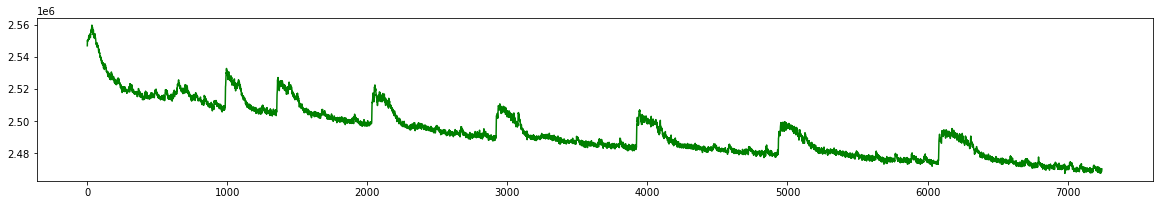

In [37]:
# Plot fluorescence
plt.figure(figsize=(20,3))
plt.plot(fluo, 'g')
plt.show()

In [23]:
# Save the results
FILE_FLUO = SAVE_DIR
df = pd.DataFrame(fluo)
df.to_csv(FILE_FLUO + 'total_fluo_' + VIDEO_NAME + '.csv', index=False)

## Compare midline length and fluorescence

In [22]:
# using this to work around nan values in midlens data
def norm_to_zero_one(df):
    return (df - df.min()) * 1.0 / (df.max() - df.min())

In [24]:
midlens = pd.DataFrame(midlens_orig[500:7000])

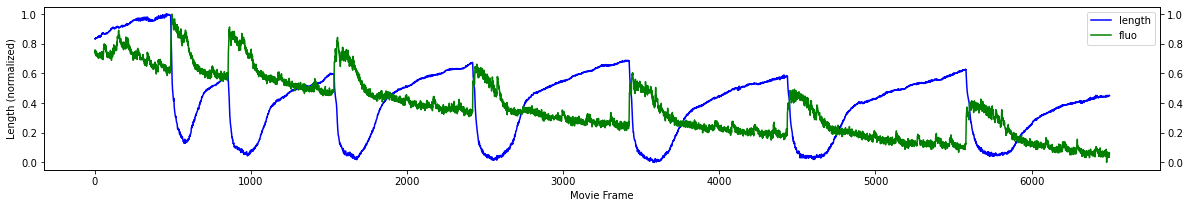

In [38]:
# Plot overlayed length and fluorescence
fluo = utils.normalize(fluo)

FPS = 4
timex = np.arange(0, len(fluo)/FPS, 1/FPS)

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
ax_ = ax.twinx()
lns1 = ax.plot(norm_to_zero_one(midlens), 'b', label='length')
# ax.plot(midlens_corr, 'b', label='corrected')
lns2 = ax_.plot(utils.normalize(fluo[500:7000]), 'g', label='fluo')
# ax.plot(midlens_corr[500:1200], 'r', label='corrected')
# ax_.plot(fluo[500:1200])
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')
ax.set(xlabel='Movie Frame', ylabel='Length (normalized)')

# save plot (without highlighting)
plt.savefig(SAVE_DIR + VIDEO_NAME + "_plot.jpg")
plt.show()

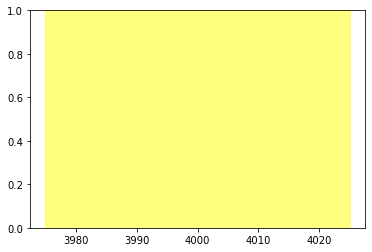

In [39]:
# highlight portion of graph to display alongside movie clip
plt.axvspan(3975, 4025, color='yellow', alpha=0.5)
plt.show()